In [2]:
%matplotlib inline

import cv2
import csv
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import sys
sys.path.append('/home/steve/git/CreateNormals/')
from python.calc_normals import NormalCalculation
from dataset.helper import *
import yaml

In [14]:
convert_to_20 = [0,1,2,3,4,5,6,7,8,9,10,11,12,9,13,20,14,20,4,20,2,0,0,0,15,20,0,0,16,0,20,0,20,17,18,20,19,0,20,20,0]
label_nyu_mapping = dict()
label_nyu_mapping[0] = 0
with open('/data4/scannetv2-labels.combined.tsv') as tsvfile:
    reader = csv.reader(tsvfile, delimiter='\t')
    start = True
    for row in reader:
        if row[4] == 'nyu40id' or int(row[4]) < 41:
            print(row[0] + ', ' + row[1] + ', ' + row[4] + ', ' + row[6])
        #print(row)
        if not start:
            label_nyu_mapping[int(row[0])] = convert_to_20(int(row[4]))
        start = False

id, raw_category, nyu40id, nyuClass
1, wall, 1, wall
2, chair, 5, chair
22, books, 23, book
3, floor, 2, floor
5, door, 8, door
1163, object, 40, 
16, window, 9, window
4, table, 7, table
56, trash can, 39, garbage bin
13, pillow, 18, pillow
15, picture, 11, picture
41, ceiling, 22, ceiling
26, box, 29, box
161, doorframe, 8, door
19, monitor, 40, monitor
7, cabinet, 3, cabinet
9, desk, 14, desk
8, shelf, 15, shelves
10, office chair, 5, chair
31, towel, 27, towel
6, couch, 6, sofa
14, sink, 34, sink
48, backpack, 40, backpack
28, lamp, 35, lamp
11, bed, 4, bed
18, bookshelf, 10, bookshelf
71, mirror, 19, mirror
21, curtain, 16, curtain
40, plant, 40, plant
52, whiteboard, 30, whiteboard
96, radiator, 39, radiator
22, book, 23, book
29, kitchen cabinet, 3, cabinet
49, toilet paper, 40, toilet paper
29, kitchen cabinets, 3, cabinet
23, armchair, 5, chair
63, shoes, 40, shoe
24, coffee table, 7, coffee table
17, toilet, 33, toilet
47, bag, 37, bag
32, clothes, 21, clothes
46, keyboard, 4

ScanNet v2 (void + 40 classes):
0: Void
1: Wall
2: Floor
3: Cabinet
4: Bed
5: Chair
6: Sofa
7: Table
8: Door
9: Window
10: Bookshelf
11: Picture
12: Counter
13: Blinds
14: Desk
15: Shelves
16: Curtain
17: Dresser
18: Pillow
19: Mirror
20: Floor Mat
21: Clothes
22: Ceiling
23: Book
24: Fridge
25: TV
26: Paper
27: Towel
28: Shower Curtain
29: Box
30: Whiteboard
31: Person
32: Night Stand
33: Toilet
34: Sink
35: Lamp
36: BathTub
37: Bag
38: Structure
39: Furniture
Other Objects: 40

In [4]:
def colorize(value, vmin=None, vmax=None, cmap=None):
    """
    A utility function for TensorFlow that maps a grayscale image to a matplotlib
    colormap for use with TensorBoard image summaries.
    By default it will normalize the input value to the range 0..1 before mapping
    to a grayscale colormap
    Arguments:
      - value: 2D Tensor of shape [height, width] or 3D Tensor of shape
        [height, width, 1].
      - vmin: the minimum value of the range used for normalization.
        (Default: value minimum)
      - vmax: the maximum value of the range used for normalization.
        (Default: value maximum)
      - cmap: a valid cmap named for use with matplotlib's `get_cmap`.
        (Default: 'gray')
    Example usage:
    ```
    output = tf.random_uniform(shape=[256, 256, 1])
    output_color = colorize(output, vmin=0.0, vmax=1.0, cmap='viridis')
    tf.summary.image('output', output_color)
    ```
    
    Returns a 3D tensor of shape [height, width, 3].
    """

    # normalize
    value = tf.cast(value, tf.uint8)
    vmin = tf.reduce_min(value) if vmin is None else vmin
    vmax = tf.reduce_max(value) if vmax is None else vmax
    value = (value - vmin) / (vmax - vmin) # vmin..vmax

    # squeeze last dim if it exists
    value = tf.squeeze(value)

    # quantize
    indices = tf.to_int32(tf.round(value * 255))

    # gather
    cm = matplotlib.cm.get_cmap('cmap if cmap is not None else 'gray'')
    colors = cm(np.arange(256))[:, :3]
    colors = tf.constant(colors, dtype=tf.float32)
    value = tf.gather(colors, indices) * 255

    return value


SyntaxError: invalid syntax (<ipython-input-4-ff048ee2d6f3>, line 39)

In [5]:
config = yaml.load(open('config/scannet_train.config'))
data_list, iterator = get_train_data(config)
with tf.Session() as sess:
    images_pl = tf.placeholder(tf.float32, [None, 480, 640, 3])
    labels_pl = tf.placeholder(tf.float32, [None, 480, 640, 41])
    argmaxed = tf.math.argmax(labels_pl, axis=-1)
    # normalize
    value = tf.cast(argmaxed, tf.float32)
    vmin = 0
    vmax = 41
    value_normed = (value - vmin) / (vmax - vmin) # vmin..vmax

    # squeeze last dim if it exists
    value_normed = tf.squeeze(value_normed)

    # quantize
    indices = tf.to_int32(tf.round(value_normed * 255))

    # gather
    cm = matplotlib.cm.get_cmap('jet')
    colors = cm(np.arange(256))[:, :3]
    colors = tf.constant(colors, dtype=tf.float32)
    label_mapped = tf.cast(tf.gather(colors, indices) * 255, tf.uint8)
    img, label = sess.run([data_list[0], data_list[1]])
    output = sess.run([argmaxed, value, value_normed, indices, colors, label_mapped], feed_dict={images_pl:img, labels_pl:label})

W0729 15:18:29.360529 139896135796480 deprecation.py:323] From dataset/helper.py:75: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
W0729 15:18:29.493438 139896135796480 deprecation.py:323] From dataset/helper.py:81: make_one_shot_iterator (from tensorflow.python.data.op

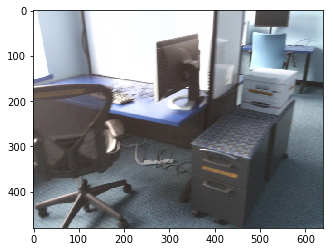

In [6]:
tmpImage = img[0,:,:,:]
plt.imshow(tmpImage.astype(np.uint8))
#print np.unique(tmpImage)

(480, 640)
[ 0  1  3  9 10 16 19 26]


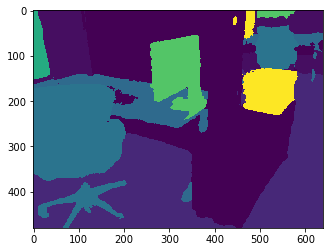

In [7]:
tmpLabel = np.argmax(label[0,:,:,:],axis=-1)
print tmpLabel.shape
plt.imshow(tmpLabel)
print np.unique(tmpLabel)

[  0  12  34  92  96 120 127 154 212 213 234 255]


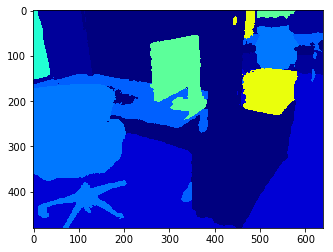

In [8]:
tmpOutput = output[5][0,:,:,:]
print np.unique(tmpOutput)
plt.imshow(tmpOutput)

[0.         0.29268293 0.82926829 2.24390244 2.34146341 2.92682927
 3.09756098 3.75609756 5.17073171 5.19512195 5.70731707 6.2195122 ]


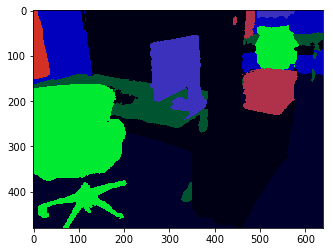

In [9]:
vmin = 0
vmax = 41
tmp = (tmpOutput.astype(np.float) - vmin) / (vmax - vmin)
print np.unique(tmp)
plt.imshow(tmp)

In [4]:
print(label_nyu_mapping)

{0: 0, 1: 1, 2: 5, 3: 2, 4: 7, 5: 8, 6: 6, 7: 3, 8: 15, 9: 14, 10: 5, 11: 4, 13: 18, 14: 34, 15: 11, 16: 9, 17: 33, 18: 10, 19: 40, 21: 16, 22: 23, 23: 5, 24: 7, 25: 39, 26: 29, 27: 24, 28: 35, 29: 3, 31: 27, 32: 21, 33: 25, 34: 32, 35: 12, 36: 17, 38: 40, 39: 18, 40: 40, 41: 22, 42: 36, 43: 39, 44: 7, 45: 7, 46: 40, 47: 37, 48: 40, 49: 40, 50: 40, 51: 39, 52: 30, 53: 40, 54: 40, 55: 28, 56: 39, 57: 39, 58: 38, 59: 40, 61: 40, 62: 38, 63: 40, 64: 40, 65: 40, 66: 40, 67: 39, 68: 39, 69: 38, 70: 39, 71: 19, 72: 40, 73: 40, 74: 5, 75: 3, 76: 40, 77: 40, 78: 38, 79: 26, 80: 31, 81: 39, 82: 40, 83: 40, 84: 38, 85: 39, 86: 13, 87: 39, 88: 40, 89: 38, 90: 39, 91: 39, 92: 40, 93: 40, 95: 38, 96: 39, 97: 39, 98: 40, 99: 39, 100: 40, 101: 40, 102: 40, 103: 40, 104: 39, 105: 38, 106: 40, 107: 38, 108: 7, 110: 39, 111: 40, 112: 40, 115: 40, 116: 39, 117: 38, 118: 40, 119: 40, 120: 38, 121: 40, 122: 39, 123: 40, 125: 38, 126: 39, 128: 1, 129: 39, 130: 40, 131: 40, 132: 40, 133: 40, 134: 40, 135: 40